# Speech Emotion Recognition - Binary Classification
## Comparing SVM, 1D-CNN, and Bi-LSTM Models

**Project Goal**: Binary emotion classification
- **Negative Emotions** (Angry, Disgust, Fear, Sad) → Label **1**
- **Non-Negative Emotions** (Happy, Neutral, Surprise) → Label **0**

**Dataset**: TESS (Toronto Emotional Speech Set) and CREMA-D merged dataset

## 1. Import Required Libraries

In [1]:
# Core libraries
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Audio processing
import librosa

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Librosa version: {librosa.__version__}")

2025-12-24 08:36:46.222012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766565406.401172      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766565406.454932      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766565406.900961      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766565406.901027      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766565406.901030      23 computation_placer.cc:177] computation placer alr

✅ All libraries imported successfully!
TensorFlow version: 2.19.0
Librosa version: 0.11.0


## 2. Configuration and Constants

In [2]:
# Dataset path (modify if needed)
DATASET_PATH = r"/kaggle/input/merged-ser-dataset1/merged_ser_dataset"

# Audio processing parameters
MAX_LEN = 100  # Fixed length for time-series (Deep Learning)
N_MFCC = 40    # Number of MFCC coefficients
SAMPLE_RATE = 22050  # Librosa default

# Emotion mappings
NEGATIVE_EMOTIONS = ['angry', 'disgust', 'fear', 'sad']
NON_NEGATIVE_EMOTIONS = ['happy', 'neutral', 'surprise']

# Binary labels
EMOTION_TO_LABEL = {
    'angry': 1,
    'disgust': 1,
    'fear': 1,
    'sad': 1,
    'happy': 0,
    'neutral': 0,
    'surprise': 0
}

print("✅ Configuration set!")
print(f"Dataset Path: {DATASET_PATH}")
print(f"Max Length: {MAX_LEN}, N_MFCC: {N_MFCC}")
print(f"Negative Emotions: {NEGATIVE_EMOTIONS}")
print(f"Non-Negative Emotions: {NON_NEGATIVE_EMOTIONS}")

✅ Configuration set!
Dataset Path: /kaggle/input/merged-ser-dataset1/merged_ser_dataset
Max Length: 100, N_MFCC: 40
Negative Emotions: ['angry', 'disgust', 'fear', 'sad']
Non-Negative Emotions: ['happy', 'neutral', 'surprise']


## 3. Data Loading Function

In [3]:
def load_dataset(dataset_path):
    """
    Load dataset by walking through directory structure.
    Extract emotion labels from folder names and filenames.
    
    Returns:
        file_paths: List of audio file paths
        labels: Binary labels (0 or 1)
        emotions: Original emotion names
    """
    file_paths = []
    labels = []
    emotions = []
    
    print("Loading dataset...")
    
    # Walk through all subdirectories
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                
                # Extract emotion from folder name or filename
                folder_name = os.path.basename(root).lower()
                filename_lower = file.lower()
                
                # Try to identify emotion
                emotion = None
                
                # Check folder name first
                for emo in EMOTION_TO_LABEL.keys():
                    if emo in folder_name:
                        emotion = emo
                        break
                
                # If not found in folder, check filename
                if emotion is None:
                    for emo in EMOTION_TO_LABEL.keys():
                        if emo in filename_lower:
                            emotion = emo
                            break
                
                # If emotion identified, add to dataset
                if emotion is not None:
                    file_paths.append(file_path)
                    labels.append(EMOTION_TO_LABEL[emotion])
                    emotions.append(emotion)
    
    print(f"✅ Loaded {len(file_paths)} audio files")
    
    # Show distribution
    label_counts = pd.Series(labels).value_counts().sort_index()
    print("\nLabel Distribution:")
    print(f"  Label 0 (Non-Negative): {label_counts.get(0, 0)} files")
    print(f"  Label 1 (Negative): {label_counts.get(1, 0)} files")
    
    # Show emotion distribution
    emotion_counts = pd.Series(emotions).value_counts()
    print("\nEmotion Distribution:")
    for emo, count in emotion_counts.items():
        print(f"  {emo.capitalize()}: {count} files")
    
    return file_paths, labels, emotions

## 4. Dual Feature Extraction Function (CRUCIAL)

In [4]:
def extract_features(file_path, max_len=MAX_LEN, n_mfcc=N_MFCC):
    """
    Extract DUAL feature sets from audio file:
    - Set A: Statistical features for SVM (80D: 40 means + 40 stds)
    - Set B: Sequential features for Deep Learning (100 x 40 time-series)
    
    Args:
        file_path: Path to audio file
        max_len: Fixed length for time-series (default 100)
        n_mfcc: Number of MFCC coefficients (default 40)
    
    Returns:
        features_svm: (80,) array for SVM
        features_dl: (max_len, n_mfcc) array for Deep Learning
    """
    try:
        # Load audio file
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=3.0)
        
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        # mfcc shape: (n_mfcc, time_steps)
        
        # SET A: Statistical features for SVM
        # Calculate mean and std across time axis
        mfcc_mean = np.mean(mfcc, axis=1)  # (40,)
        mfcc_std = np.std(mfcc, axis=1)    # (40,)
        features_svm = np.concatenate([mfcc_mean, mfcc_std])  # (80,)
        
        # SET B: Sequential features for Deep Learning
        # Transpose to get (time_steps, n_mfcc)
        mfcc_seq = mfcc.T  # (time_steps, 40)
        
        # Pad or truncate to fixed length
        if mfcc_seq.shape[0] < max_len:
            # Pad with zeros
            pad_width = max_len - mfcc_seq.shape[0]
            features_dl = np.pad(mfcc_seq, ((0, pad_width), (0, 0)), mode='constant')
        else:
            # Truncate
            features_dl = mfcc_seq[:max_len, :]
        
        return features_svm, features_dl
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        # Return zero features on error
        features_svm = np.zeros(n_mfcc * 2)
        features_dl = np.zeros((max_len, n_mfcc))
        return features_svm, features_dl

## 5. Load Dataset

In [5]:
# Load all file paths and labels
file_paths, labels, emotions = load_dataset(DATASET_PATH)

Loading dataset...
✅ Loaded 12162 audio files

Label Distribution:
  Label 0 (Non-Negative): 4470 files
  Label 1 (Negative): 7692 files

Emotion Distribution:
  Fear: 1923 files
  Angry: 1923 files
  Sad: 1923 files
  Happy: 1923 files
  Disgust: 1923 files
  Neutral: 1895 files
  Surprise: 652 files


## 6. Extract Features for All Audio Files

In [6]:
# Extract both feature sets
print("Extracting features from all audio files...")
print("This may take a few minutes...\n")

features_svm_list = []
features_dl_list = []

for i, file_path in enumerate(file_paths):
    if (i + 1) % 500 == 0:
        print(f"Processed {i + 1}/{len(file_paths)} files...")
    
    feat_svm, feat_dl = extract_features(file_path)
    features_svm_list.append(feat_svm)
    features_dl_list.append(feat_dl)

# Convert to numpy arrays
X_svm = np.array(features_svm_list)  # Shape: (n_samples, 80)
X_dl = np.array(features_dl_list)    # Shape: (n_samples, 100, 40)
y = np.array(labels)                  # Shape: (n_samples,)

print(f"\n✅ Feature extraction complete!")
print(f"\nFeature Set A (SVM): {X_svm.shape}")
print(f"Feature Set B (Deep Learning): {X_dl.shape}")
print(f"Labels: {y.shape}")

Extracting features from all audio files...
This may take a few minutes...

Processed 500/12162 files...
Processed 1000/12162 files...
Processed 1500/12162 files...
Processed 2000/12162 files...
Processed 2500/12162 files...
Processed 3000/12162 files...
Processed 3500/12162 files...
Processed 4000/12162 files...
Processed 4500/12162 files...
Processed 5000/12162 files...
Processed 5500/12162 files...
Processed 6000/12162 files...
Processed 6500/12162 files...
Processed 7000/12162 files...
Processed 7500/12162 files...
Processed 8000/12162 files...
Processed 8500/12162 files...
Processed 9000/12162 files...
Processed 9500/12162 files...
Processed 10000/12162 files...
Processed 10500/12162 files...
Processed 11000/12162 files...
Processed 11500/12162 files...
Processed 12000/12162 files...

✅ Feature extraction complete!

Feature Set A (SVM): (12162, 80)
Feature Set B (Deep Learning): (12162, 100, 40)
Labels: (12162,)


## 7. Train-Test Split (Using Same Indices for Fair Comparison)

In [7]:
# Stratified split to maintain class balance
from sklearn.model_selection import train_test_split

# Split indices (not the data directly)
indices = np.arange(len(y))
train_idx, test_idx = train_test_split(
    indices, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# Split Set A (SVM features)
X_train_svm = X_svm[train_idx]
X_test_svm = X_svm[test_idx]

# Split Set B (Deep Learning features)
X_train_dl = X_dl[train_idx]
X_test_dl = X_dl[test_idx]

# Split labels
y_train = y[train_idx]
y_test = y[test_idx]

print("✅ Train-Test Split Complete!")
print(f"\nTraining samples: {len(y_train)}")
print(f"Testing samples: {len(y_test)}")
print(f"\nTraining set label distribution:")
print(f"  Label 0: {np.sum(y_train == 0)} samples")
print(f"  Label 1: {np.sum(y_train == 1)} samples")
print(f"\nTesting set label distribution:")
print(f"  Label 0: {np.sum(y_test == 0)} samples")
print(f"  Label 1: {np.sum(y_test == 1)} samples")

✅ Train-Test Split Complete!

Training samples: 9729
Testing samples: 2433

Training set label distribution:
  Label 0: 3576 samples
  Label 1: 6153 samples

Testing set label distribution:
  Label 0: 894 samples
  Label 1: 1539 samples


## 8. Model 1: SVM with RBF Kernel

In [8]:
def train_svm_model(X_train, X_test, y_train, y_test):
    """
    Train SVM model with RBF kernel using Set A (statistical features).
    
    Returns:
        model: Trained SVM model
        accuracy: Test accuracy
        f1: Test F1-score
        y_pred: Predictions
    """
    print("\n" + "="*60)
    print("Training SVM Model with RBF Kernel")
    print("="*60)
    
    # Standard scaling (important for SVM)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train SVM
    print("Training SVM...")
    model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    
    print(f"\n✅ SVM Training Complete!")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return model, scaler, accuracy, f1, y_pred

# Train SVM
svm_model, svm_scaler, svm_accuracy, svm_f1, svm_predictions = train_svm_model(
    X_train_svm, X_test_svm, y_train, y_test
)


Training SVM Model with RBF Kernel
Training SVM...

✅ SVM Training Complete!
Accuracy: 0.7920
F1-Score: 0.8497


## 9. Model 2: 1D-CNN (Simple Deep Learning Baseline)

In [9]:
def create_cnn_model(input_shape):
    """
    Create 1D-CNN model for sequential features (Set B).
    
    Args:
        input_shape: (max_len, n_mfcc) e.g., (100, 40)
    
    Returns:
        model: Compiled Keras model
    """
    model = Sequential([
        # First Conv block
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # Second Conv block
        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # Third Conv block
        Conv1D(256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # Flatten and Dense layers
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def train_cnn_model(X_train, X_test, y_train, y_test, epochs=50, batch_size=32):
    """
    Train 1D-CNN model.
    
    Returns:
        model: Trained model
        history: Training history
        accuracy: Test accuracy
        f1: Test F1-score
        y_pred: Predictions
    """
    print("\n" + "="*60)
    print("Training 1D-CNN Model")
    print("="*60)
    
    # Create model
    model = create_cnn_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    print("\nModel Architecture:")
    model.summary()
    
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
    
    # Train
    print("\nTraining CNN...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # Predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    
    print(f"\n✅ CNN Training Complete!")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return model, history, accuracy, f1, y_pred

# Train CNN
cnn_model, cnn_history, cnn_accuracy, cnn_f1, cnn_predictions = train_cnn_model(
    X_train_dl, X_test_dl, y_train, y_test
)


Training 1D-CNN Model


I0000 00:00:1766565675.221274      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766565675.225177      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 98, 64)         │         7,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 47, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 21, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 469,441 (1.79 MB)

 Trainable params: 468,289 (1.79 MB)

 Non-trainable params: 1,152 (4.50 KB)


Training CNN...
Epoch 1/50


I0000 00:00:1766565680.328360      76 service.cc:152] XLA service 0x7de0c80046f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766565680.328398      76 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766565680.328401      76 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766565680.994092      76 cuda_dnn.cc:529] Loaded cuDNN version 91002


 37/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4374 - loss: 1.2786

I0000 00:00:1766565686.379195      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


305/305 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.5925 - loss: 0.8677 - val_accuracy: 0.7271 - val_loss: 0.5061 - learning_rate: 0.0010
Epoch 2/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7228 - loss: 0.5171 - val_accuracy: 0.7452 - val_loss: 0.4911 - learning_rate: 0.0010
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7346 - loss: 0.4859 - val_accuracy: 0.7493 - val_loss: 0.4418 - learning_rate: 0.0010
Epoch 4/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7500 - loss: 0.4556 - val_accuracy: 0.7542 - val_loss: 0.4363 - learning_rate: 0.0010
Epoch 5/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7514 - loss: 0.4509 - val_accuracy: 0.7559 - val_loss: 0.4303 - learning_rate: 0.0010
Epoch 6/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7628 - loss: 0.4372 - val_accuracy: 0.7674 - val_loss: 0.4313 - learning_rate: 0.0010
Epoch 7/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7810 - loss: 0.4200 - val_accur

## 10. Model 3: Bi-LSTM (Proposed Model)

In [10]:
# ============================================================================
# CELL: Model 3 - OPTIMIZED Bi-LSTM (SOLUSI UNTUK AKURASI RENDAH)
# Ganti cell yang lama dengan ini
# ============================================================================

def create_bilstm_model_optimized(input_shape):
    """
    OPTIMIZED Bidirectional LSTM dengan arsitektur yang lebih efisien.
    
    PERUBAHAN KUNCI:
    - Reduced layer complexity (256→128→64) untuk cegah overfitting
    - Dropout lebih agresif (0.4-0.5)
    - Batch Normalization setelah setiap layer
    - L2 regularization lebih kuat
    - Learning rate optimal (0.001)
    """
    from tensorflow.keras.regularizers import l2
    from tensorflow.keras.optimizers import Adam
    
    model = Sequential([
        # First Bi-LSTM layer (reduced from 128 to 64)
        Bidirectional(
            LSTM(64, return_sequences=True, 
                 dropout=0.4,  # Increased
                 recurrent_dropout=0.3,  # Increased
                 kernel_regularizer=l2(0.01)),  # Stronger regularization
            input_shape=input_shape
        ),
        BatchNormalization(),
        
        # Second Bi-LSTM layer
        Bidirectional(
            LSTM(32, return_sequences=False,  # Reduced complexity
                 dropout=0.4,
                 recurrent_dropout=0.3,
                 kernel_regularizer=l2(0.01))
        ),
        BatchNormalization(),
        Dropout(0.5),
        
        # Dense layers (simplified)
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.4),
        
        Dense(1, activation='sigmoid')
    ])
    
    # Optimal learning rate
    optimizer = Adam(learning_rate=0.001)  # Higher than before
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def train_bilstm_model_optimized(X_train, X_test, y_train, y_test):
    """
    Training function dengan hyperparameter yang OPTIMAL.
    
    PERUBAHAN:
    - Epochs dikurangi (50 instead of 100)
    - Batch size lebih besar (32 instead of 16) untuk speed
    - Early stopping lebih ketat (patience=8)
    - ReduceLR lebih agresif
    """
    print("\n" + "="*70)
    print("TRAINING OPTIMIZED BI-LSTM MODEL")
    print("="*70)
    print("\n🔧 Key Optimizations:")
    print("  ✓ Reduced model complexity (64→32 LSTM units)")
    print("  ✓ Stronger regularization (dropout 0.4-0.5, L2=0.01)")
    print("  ✓ Optimal learning rate (0.001)")
    print("  ✓ Larger batch size (32) for faster training")
    print("  ✓ Aggressive early stopping (patience=8)")
    
    # Create model
    model = create_bilstm_model_optimized(
        input_shape=(X_train.shape[1], X_train.shape[2])
    )
    
    print("\n📐 Model Architecture:")
    model.summary()
    
    # Optimized Callbacks
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=8,  # Reduced from 15
        restore_best_weights=True,
        mode='max',
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Less aggressive
        patience=4,  # Trigger faster
        min_lr=1e-6,
        verbose=1
    )
    
    # Train with optimal settings
    print("\n🚀 Starting training...")
    import time
    start_time = time.time()
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,  # Reduced from 100
        batch_size=32,  # Increased from 16
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    training_time = time.time() - start_time
    
    # Predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    
    # Training metrics
    final_epoch = len(history.history['accuracy'])
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    
    print(f"\n✅ TRAINING COMPLETE!")
    print(f"{'='*70}")
    print(f"⏱️  Training Time: {training_time/60:.1f} minutes ({final_epoch} epochs)")
    print(f"📊 Final Metrics:")
    print(f"   Train Accuracy:      {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"   Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"   Test Accuracy:       {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Test F1-Score:       {f1:.4f}")
    print(f"\n🔍 Overfitting Analysis:")
    print(f"   Train-Val Gap:  {abs(train_acc - val_acc)*100:.2f}%")
    print(f"   Train-Test Gap: {abs(train_acc - accuracy)*100:.2f}%")
    
    if abs(train_acc - accuracy) < 0.05:
        print(f"   ✅ Good generalization (gap < 5%)")
    else:
        print(f"   ⚠️  Possible overfitting (gap > 5%)")
    
    return model, history, accuracy, f1, y_pred

# ============================================================================
# TRAIN THE OPTIMIZED MODEL
# ============================================================================
print("\n" + "🎯"*35)
print("STARTING OPTIMIZED BI-LSTM TRAINING")
print("🎯"*35)

bilstm_model, bilstm_history, bilstm_accuracy, bilstm_f1, bilstm_predictions = train_bilstm_model_optimized(
    X_train_dl, X_test_dl, y_train, y_test
)

print("\n" + "="*70)
print("✅ Optimized Bi-LSTM training completed!")
print("="*70)


🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
STARTING OPTIMIZED BI-LSTM TRAINING
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

TRAINING OPTIMIZED BI-LSTM MODEL

🔧 Key Optimizations:
  ✓ Reduced model complexity (64→32 LSTM units)
  ✓ Stronger regularization (dropout 0.4-0.5, L2=0.01)
  ✓ Optimal learning rate (0.001)
  ✓ Larger batch size (32) for faster training
  ✓ Aggressive early stopping (patience=8)

📐 Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        53,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,273 (399.50 KB)

 Trainable params: 101,761 (397.50 KB)

 Non-trainable params: 512 (2.00 KB)


🚀 Starting training...
Epoch 1/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 274s 852ms/step - accuracy: 0.5579 - loss: 4.9334 - val_accuracy: 0.6482 - val_loss: 2.8711 - learning_rate: 0.0010
Epoch 2/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 257s 844ms/step - accuracy: 0.5898 - loss: 2.5549 - val_accuracy: 0.6326 - val_loss: 1.7244 - learning_rate: 0.0010
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 262s 843ms/step - accuracy: 0.6126 - loss: 1.5918 - val_accuracy: 0.6338 - val_loss: 1.2066 - learning_rate: 0.0010
Epoch 4/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 256s 840ms/step - accuracy: 0.6292 - loss: 1.1408 - val_accuracy: 0.6728 - val_loss: 0.9559 - learning_rate: 0.0010
Epoch 5/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 256s 839ms/step - accuracy: 0.6506 - loss: 0.9204 - val_accuracy: 0.6695 - val_loss: 0.8201 - learning_rate: 0.0010
Epoch 6/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 256s 839ms/step - accuracy: 0.6693 - loss: 0.8093 - val_accuracy: 0.6815 - val_loss: 0.7430 - learning_rate: 0.0010
Epoch 7/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 

## 11. Comparison Table - All Models

In [11]:
# Create comparison table
comparison_data = {
    'Model': ['SVM (RBF)', '1D-CNN', 'Bi-LSTM'],
    'Accuracy': [svm_accuracy, cnn_accuracy, bilstm_accuracy],
    'F1-Score': [svm_f1, cnn_f1, bilstm_f1]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*60)
print("MODEL COMPARISON TABLE")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

# Find best model
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_f1 = comparison_df.loc[best_model_idx, 'F1-Score']

print(f"\n🏆 Best Model: {best_model_name} (F1-Score: {best_f1:.4f})")


MODEL COMPARISON TABLE
    Model  Accuracy  F1-Score
SVM (RBF)  0.792026  0.849673
   1D-CNN  0.819564  0.854684
  Bi-LSTM  0.727086  0.822460

🏆 Best Model: 1D-CNN (F1-Score: 0.8547)


## 12. Visualization: Performance Comparison

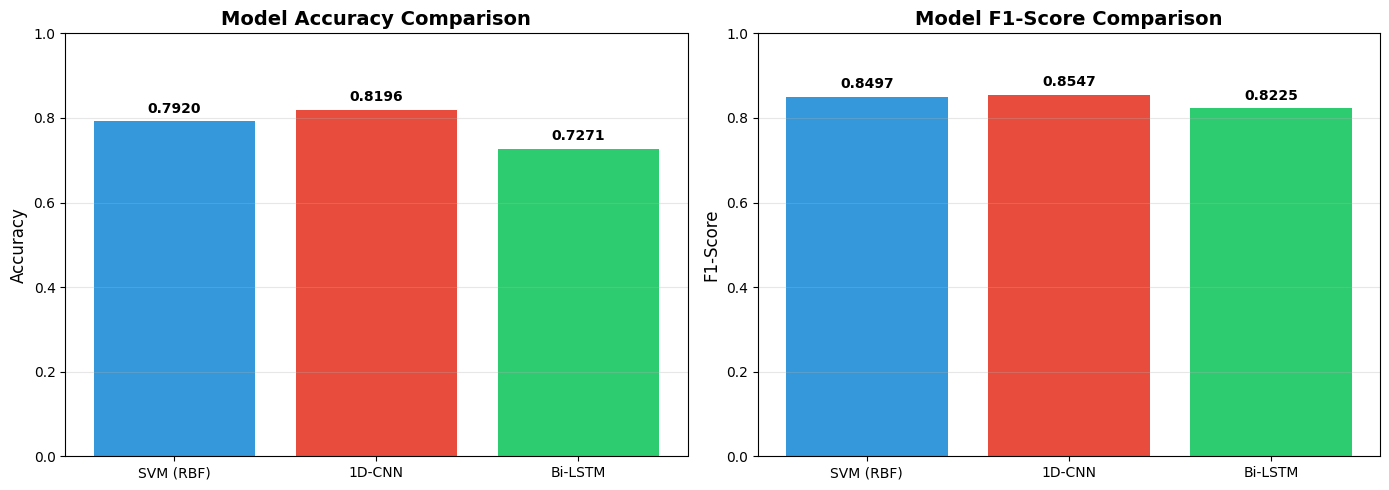

In [12]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].bar(comparison_df['Model'], comparison_df['Accuracy'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=10, fontweight='bold')

# F1-Score comparison
axes[1].bar(comparison_df['Model'], comparison_df['F1-Score'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['F1-Score']):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 13. Confusion Matrices - Side by Side

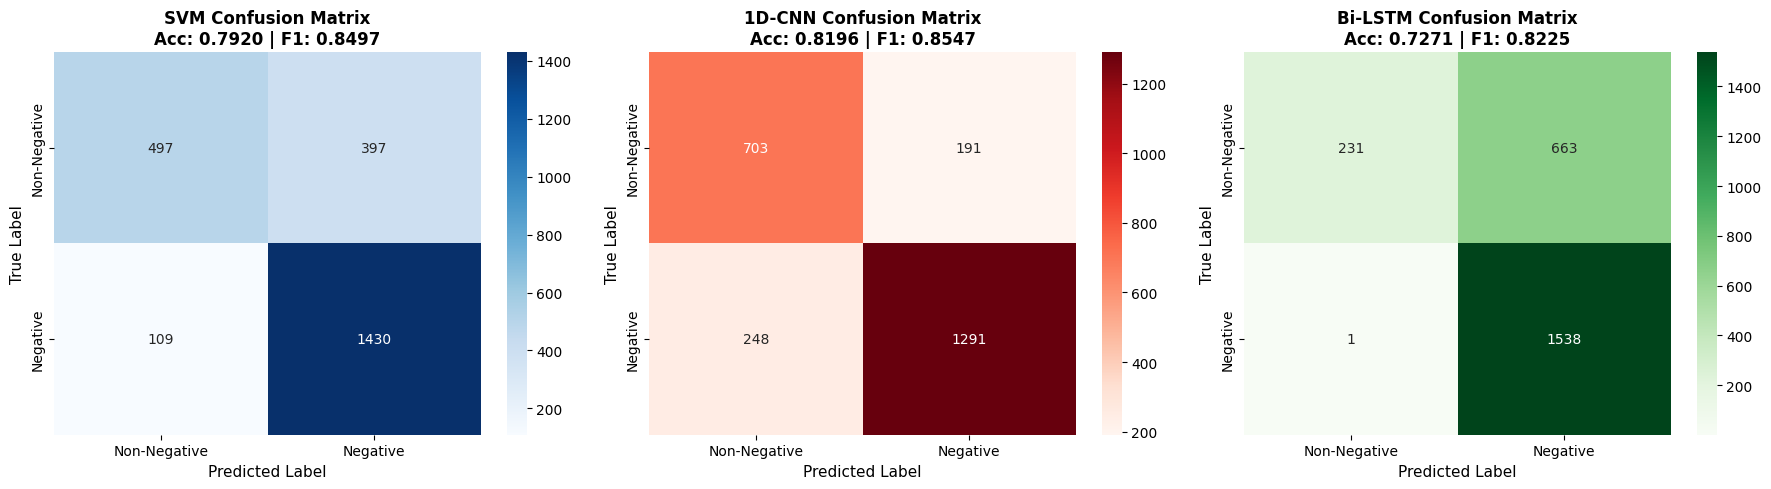

In [13]:
# Create confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# SVM Confusion Matrix
cm_svm = confusion_matrix(y_test, svm_predictions)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Non-Negative', 'Negative'], 
            yticklabels=['Non-Negative', 'Negative'])
axes[0].set_title(f'SVM Confusion Matrix\nAcc: {svm_accuracy:.4f} | F1: {svm_f1:.4f}', 
                 fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)

# CNN Confusion Matrix
cm_cnn = confusion_matrix(y_test, cnn_predictions)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=['Non-Negative', 'Negative'], 
            yticklabels=['Non-Negative', 'Negative'])
axes[1].set_title(f'1D-CNN Confusion Matrix\nAcc: {cnn_accuracy:.4f} | F1: {cnn_f1:.4f}', 
                 fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('Predicted Label', fontsize=11)

# Bi-LSTM Confusion Matrix
cm_bilstm = confusion_matrix(y_test, bilstm_predictions)
sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap='Greens', ax=axes[2],
            xticklabels=['Non-Negative', 'Negative'], 
            yticklabels=['Non-Negative', 'Negative'])
axes[2].set_title(f'Bi-LSTM Confusion Matrix\nAcc: {bilstm_accuracy:.4f} | F1: {bilstm_f1:.4f}', 
                 fontsize=12, fontweight='bold')
axes[2].set_ylabel('True Label', fontsize=11)
axes[2].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()

## 14. Training History - Deep Learning Models

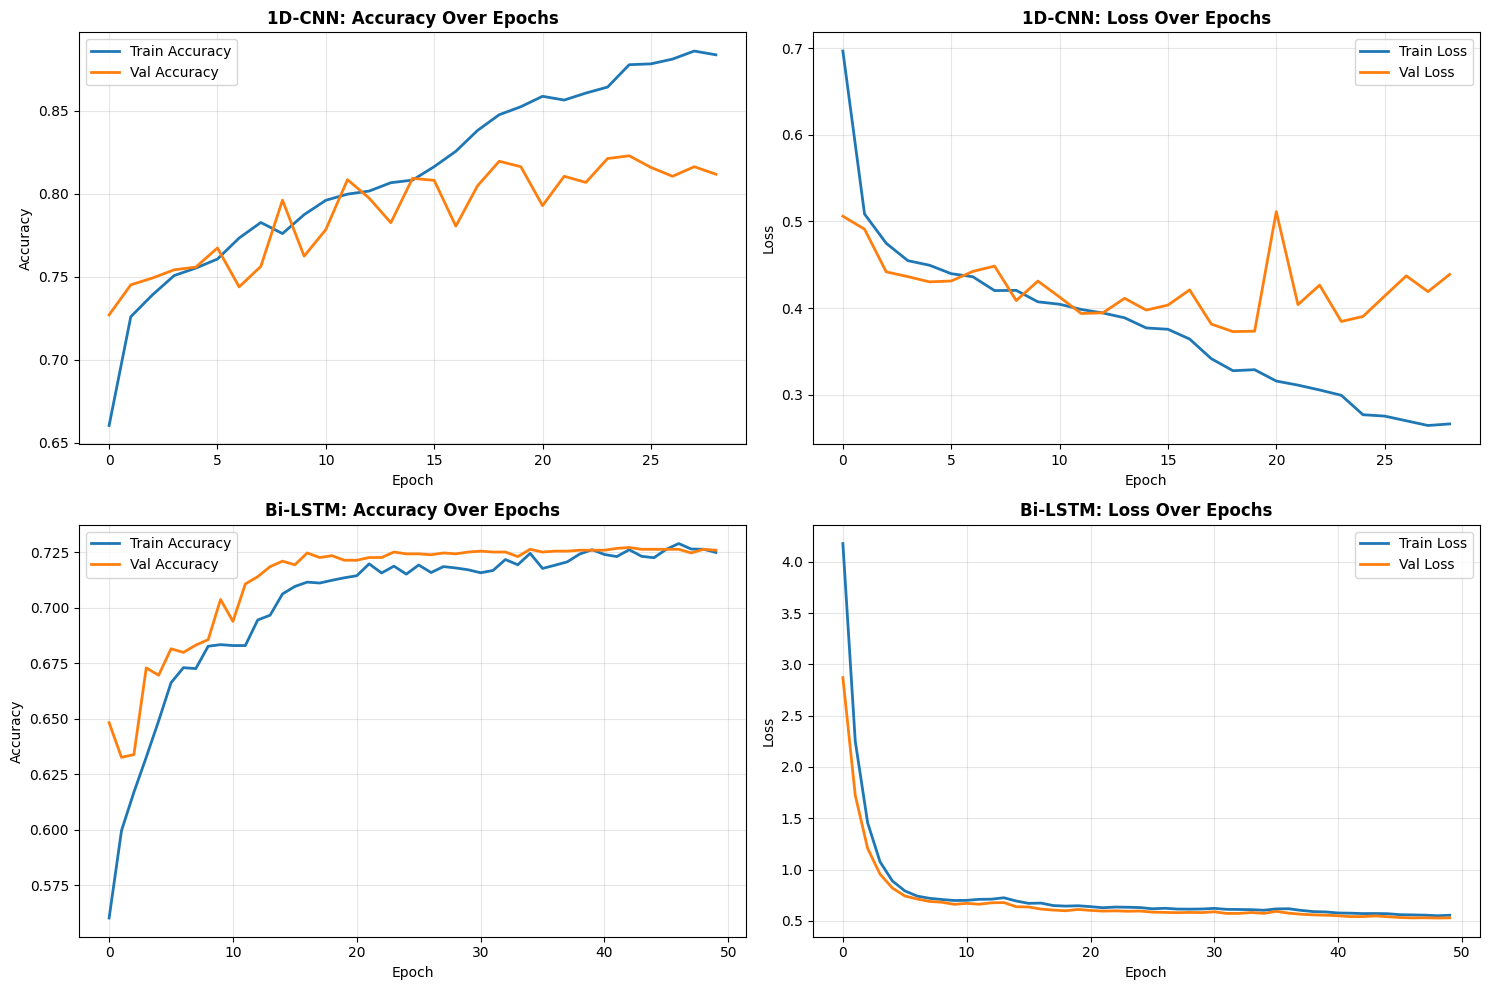

In [14]:
# Plot training history for CNN and Bi-LSTM
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# CNN - Accuracy
axes[0, 0].plot(cnn_history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 0].plot(cnn_history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 0].set_title('1D-CNN: Accuracy Over Epochs', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# CNN - Loss
axes[0, 1].plot(cnn_history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 1].plot(cnn_history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 1].set_title('1D-CNN: Loss Over Epochs', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Bi-LSTM - Accuracy
axes[1, 0].plot(bilstm_history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1, 0].plot(bilstm_history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1, 0].set_title('Bi-LSTM: Accuracy Over Epochs', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Bi-LSTM - Loss
axes[1, 1].plot(bilstm_history.history['loss'], label='Train Loss', linewidth=2)
axes[1, 1].plot(bilstm_history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1, 1].set_title('Bi-LSTM: Loss Over Epochs', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 15. Detailed Classification Reports

In [15]:
# Print detailed classification reports
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORTS")
print("="*60)

print("\n" + "-"*60)
print("SVM (RBF) - Classification Report")
print("-"*60)
print(classification_report(y_test, svm_predictions, 
                          target_names=['Non-Negative', 'Negative']))

print("\n" + "-"*60)
print("1D-CNN - Classification Report")
print("-"*60)
print(classification_report(y_test, cnn_predictions, 
                          target_names=['Non-Negative', 'Negative']))

print("\n" + "-"*60)
print("Bi-LSTM - Classification Report")
print("-"*60)
print(classification_report(y_test, bilstm_predictions, 
                          target_names=['Non-Negative', 'Negative']))


DETAILED CLASSIFICATION REPORTS

------------------------------------------------------------
SVM (RBF) - Classification Report
------------------------------------------------------------
              precision    recall  f1-score   support

Non-Negative       0.82      0.56      0.66       894
    Negative       0.78      0.93      0.85      1539

    accuracy                           0.79      2433
   macro avg       0.80      0.74      0.76      2433
weighted avg       0.80      0.79      0.78      2433


------------------------------------------------------------
1D-CNN - Classification Report
------------------------------------------------------------
              precision    recall  f1-score   support

Non-Negative       0.74      0.79      0.76       894
    Negative       0.87      0.84      0.85      1539

    accuracy                           0.82      2433
   macro avg       0.81      0.81      0.81      2433
weighted avg       0.82      0.82      0.82      2433


-

## 16. Summary and Conclusions

In [16]:
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

print(f"\n📊 Dataset Information:")
print(f"   Total samples: {len(y)}")
print(f"   Training samples: {len(y_train)}")
print(f"   Testing samples: {len(y_test)}")

print(f"\n🎯 Task: Binary Classification")
print(f"   Label 0 (Non-Negative): Happy, Neutral, Surprise")
print(f"   Label 1 (Negative): Angry, Disgust, Fear, Sad")

print(f"\n🔧 Feature Extraction:")
print(f"   Set A (SVM): Statistical features (80D: 40 means + 40 stds)")
print(f"   Set B (Deep Learning): Sequential MFCC (100 x 40)")

print(f"\n📈 Model Performance:")
for idx, row in comparison_df.iterrows():
    print(f"   {row['Model']:12} → Accuracy: {row['Accuracy']:.4f} | F1-Score: {row['F1-Score']:.4f}")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")

print(f"\n✅ All models trained and evaluated successfully!")
print("="*60)


FINAL SUMMARY

📊 Dataset Information:
   Total samples: 12162
   Training samples: 9729
   Testing samples: 2433

🎯 Task: Binary Classification
   Label 0 (Non-Negative): Happy, Neutral, Surprise
   Label 1 (Negative): Angry, Disgust, Fear, Sad

🔧 Feature Extraction:
   Set A (SVM): Statistical features (80D: 40 means + 40 stds)
   Set B (Deep Learning): Sequential MFCC (100 x 40)

📈 Model Performance:
   SVM (RBF)    → Accuracy: 0.7920 | F1-Score: 0.8497
   1D-CNN       → Accuracy: 0.8196 | F1-Score: 0.8547
   Bi-LSTM      → Accuracy: 0.7271 | F1-Score: 0.8225

🏆 Best Model: 1D-CNN
   F1-Score: 0.8547

✅ All models trained and evaluated successfully!
